## Imports

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Loading the data

In [2]:
people_df = pd.read_csv("./data/data_people_dump.zip", usecols=[1, 2, 3, 4])
people_df.drop_duplicates(subset='uuid', inplace=True)
people_df.set_index('uuid', inplace=True)

df = pd.read_csv('./data/data_survey_dump.zip')

df = df[(df.selected != 0) & (~df.uuid.isna())]
df['not_selected'] = np.where(df.selected != df.option_a, df.option_a, df.option_b)

## Defining the functions to create and analyze the graphs

In [3]:
def pref_graph_from_df(df_user, default_edge_params=None):
    default_edge_params = default_edge_params if default_edge_params is not None else {}
    
    g = nx.DiGraph()
    for record in df_user.itertuples():
        g.add_edge(record.selected, record.not_selected, **default_edge_params)
    
    return g


def find_n_cycles(graph, max_n_cycles=100):
    cyles_iterator = nx.simple_cycles(graph)
    cycles = []
    for __ in range(max_n_cycles):
        try:
            cycle = next(cyles_iterator)
            cycles.append(cycle)
        except StopIteration:
            break
    
    return cycles


def check_possible_inconsistencies(df_user):
    g = pref_graph_from_df(df_user)
    try:
        nx.find_cycle(g, orientation='ignore')
        return True
    except nx.exception.NetworkXNoCycle:
        return False


def find_inconsistencies(df_user, max_n_inconsistencies=100):
    g = pref_graph_from_df(df_user)
    inconsistencies = find_n_cycles(g, max_n_cycles=max_n_inconsistencies)
    return pd.Series([inconsistencies])


def draw_preferences_graph(df_user, max_cycles=100):    
    default_edge_parameters = {'edge_line_color': 'black', 'edge_line_width': 0.3, 'weight': 1}
    g = pref_graph_from_df(df_user, default_edge_parameters)
    cycles = find_n_cycles(g, max_cycles)

    for cycle in cycles:
        cycle_shifted = cycle[1:] + cycle[:1]
        paired_cycle_nodes = zip(cycle, cycle_shifted)
        for start_node, end_node in paired_cycle_nodes:
            cycle_edge_parameters = {'edge_line_color': 'red', 'edge_line_width': 1.5, 'weight': 0.001}
            g.add_edge(start_node, end_node, **cycle_edge_parameters)

    edge_line_colors = list(nx.get_edge_attributes(g, 'edge_line_color').values())
    edge_line_widths = list(nx.get_edge_attributes(g, 'edge_line_width').values())
    node_labels = dict(zip(g.nodes, g.nodes))

    plt.figure(figsize=(20, 10))
    
    pos = nx.spring_layout(g, weight='weight')
    nx.draw_networkx_edges(g, pos, edge_color=edge_line_colors, width=edge_line_widths, arrowsize=17)
    nx.draw_networkx_nodes(g, pos, node_size=600, alpha=0.5)
    nx.draw_networkx_labels(g, pos, node_labels, font_weight='bold', font_size=12)

    uuid = df_user.uuid.iloc[0]
    plt.title(f"Preferences of {uuid} (#Inconsistencies = {len(cycles)})")
    plt.show()


def count_unique_options(df_user):
    all_options = pd.concat([df_user.selected, df_user.not_selected])
    unique_options = all_options.unique()
    return len(unique_options)

In [4]:
sample_uuids = df.uuid.drop_duplicates()#.sample()
sample_df = df[df.uuid.isin(sample_uuids)].copy()

gr_data = pd.DataFrame(index=sample_df.uuid.drop_duplicates())

gr_data['n_questions'] = sample_df.groupby('uuid').size()
gr_data['n_unique_options'] = sample_df.groupby('uuid').apply(count_unique_options)
gr_data['inconsistencies'] = sample_df.groupby('uuid').apply(find_inconsistencies)
gr_data['has_possible_inconsistencies'] = sample_df.groupby('uuid').apply(check_possible_inconsistencies)

gr_data['n_nonunique_options'] = gr_data.n_questions*2
gr_data['n_inconsistencies'] = gr_data.inconsistencies.apply(len)
gr_data['has_inconsistencies'] = gr_data.n_inconsistencies > 0

gr_data['options_density'] = 1 - (gr_data.n_unique_options/gr_data.n_nonunique_options)

## Random example

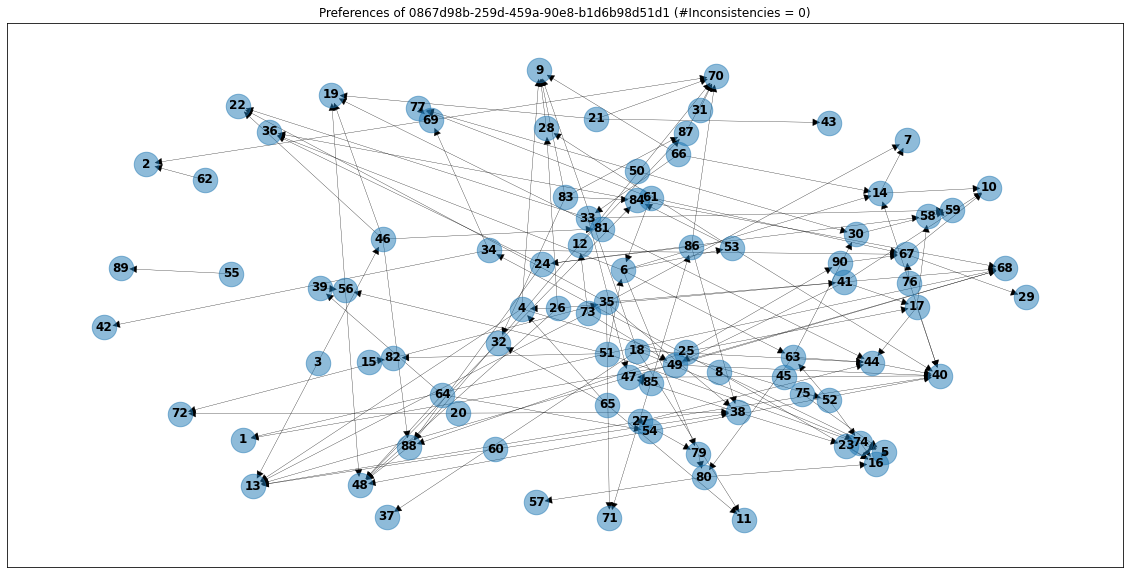

In [5]:
sample_user = df.uuid.drop_duplicates().sample().iloc[0]
user_df = df[df.uuid == sample_user]
draw_preferences_graph(user_df)

## Percentage of users that show intransitive preferences

In [7]:
percentage_intransitive = 100*(gr_data.has_inconsistencies.sum() / gr_data.has_possible_inconsistencies.sum())
print(f"Percentage of users who can show intransitive preferences and actualy show one or more {percentage_intransitive:.4}")

Percentage of users who can show intransitive preferences and actualy show one or more 38.4
